# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 19, 0, 26, 8, 193694)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
with open('../../data/hopsworkKey.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1170584
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='9.572286E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.72s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-20 00:00:00+00:00,11.50,0.0,0.509117,135.000107,chengdu
1,2024-11-22 00:00:00+00:00,13.20,0.1,3.671294,11.309896,chengdu
2,2024-11-21 00:00:00+00:00,12.50,0.0,3.671294,11.309896,chengdu
3,2024-11-23 00:00:00+00:00,12.35,0.0,5.588703,14.931467,chengdu
4,2024-11-24 00:00:00+00:00,10.75,0.0,7.172949,17.525669,chengdu
5,2024-11-25 00:00:00+00:00,6.95,0.0,6.519877,173.659897,chengdu
6,2024-11-26 00:00:00+00:00,6.45,0.0,4.610250,308.659821,chengdu
7,2024-11-27 00:00:00+00:00,8.25,0.0,4.104631,15.255177,chengdu


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [8]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2024-11-20 00:00:00+00:00,11.50,0.0,0.509117,135.000107,chengdu,131.698090
1,2024-11-22 00:00:00+00:00,13.20,0.1,3.671294,11.309896,chengdu,108.420639
2,2024-11-19 00:00:00+00:00,10.40,0.0,5.937272,14.036275,chengdu,168.471848
3,2024-11-21 00:00:00+00:00,12.50,0.0,3.671294,11.309896,chengdu,119.538330
4,2024-11-23 00:00:00+00:00,12.35,0.0,5.588703,14.931467,chengdu,128.954041
5,2024-11-24 00:00:00+00:00,10.75,0.0,7.172949,17.525669,chengdu,133.717133
6,2024-11-25 00:00:00+00:00,6.95,0.0,6.519877,173.659897,chengdu,133.763641
7,2024-11-26 00:00:00+00:00,6.45,0.0,4.610250,308.659821,chengdu,170.088654
8,2024-11-27 00:00:00+00:00,8.25,0.0,4.104631,15.255177,chengdu,161.013489


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 0 to 7
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         8 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          8 non-null      float32            
 2   precipitation_sum            8 non-null      float32            
 3   wind_speed_10m_max           8 non-null      float32            
 4   wind_direction_10m_dominant  8 non-null      float32            
 5   city                         8 non-null      object             
 6   street                       8 non-null      object             
 7   country                      8 non-null      object             
 8   days_before_forecast_day     8 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(4), int64(1), object(3)
memory usage: 512.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [12]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,street,country,days_before_forecast_day
0,2024-11-20 00:00:00+00:00,11.50,0.0,0.509117,135.000107,chengdu,chengdu-jinbo-road,china,1
2,2024-11-21 00:00:00+00:00,12.50,0.0,3.671294,11.309896,chengdu,chengdu-jinbo-road,china,2
1,2024-11-22 00:00:00+00:00,13.20,0.1,3.671294,11.309896,chengdu,chengdu-jinbo-road,china,3
3,2024-11-23 00:00:00+00:00,12.35,0.0,5.588703,14.931467,chengdu,chengdu-jinbo-road,china,4
4,2024-11-24 00:00:00+00:00,10.75,0.0,7.172949,17.525669,chengdu,chengdu-jinbo-road,china,5
5,2024-11-25 00:00:00+00:00,6.95,0.0,6.519877,173.659897,chengdu,chengdu-jinbo-road,china,6
6,2024-11-26 00:00:00+00:00,6.45,0.0,4.610250,308.659821,chengdu,chengdu-jinbo-road,china,7
7,2024-11-27 00:00:00+00:00,8.25,0.0,4.104631,15.255177,chengdu,chengdu-jinbo-road,china,8


In [13]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 0 to 7
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         8 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          8 non-null      float32            
 2   precipitation_sum            8 non-null      float32            
 3   wind_speed_10m_max           8 non-null      float32            
 4   wind_direction_10m_dominant  8 non-null      float32            
 5   city                         8 non-null      object             
 6   street                       8 non-null      object             
 7   country                      8 non-null      object             
 8   days_before_forecast_day     8 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(4), int64(1), object(3)
memory usage: 512.0+ bytes


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

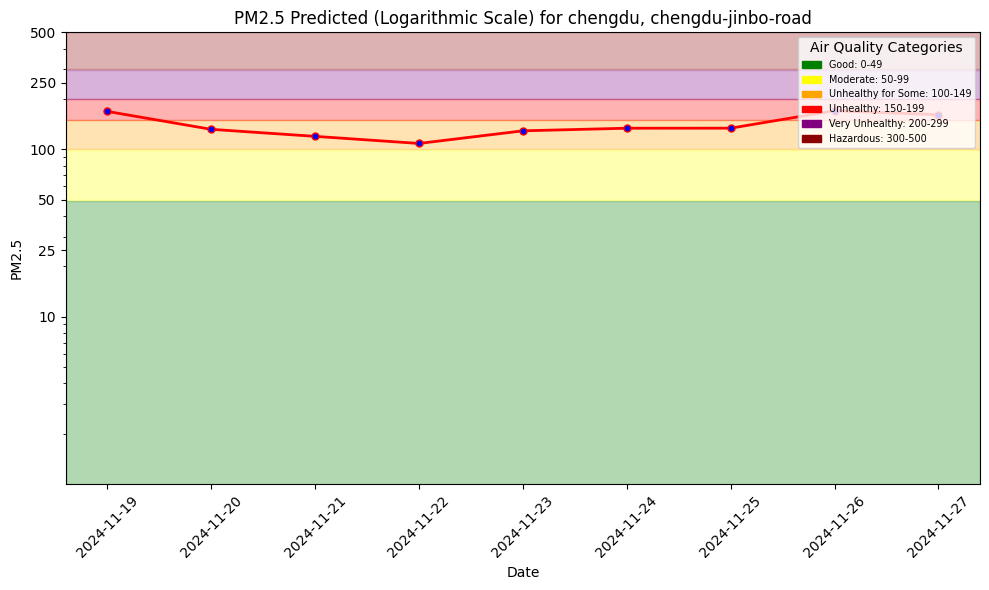

In [11]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [15]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [ ]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1170584/jobs/named/aq_predictions_1_offline_fg_materialization/executions


In [45]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
# monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df = monitor_fg.read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-19 00:00:00+00:00,10.550000,0.0,2.305125,38.659828,chengdu,191.314133,chengdu-jinbo-road,china,4
1,2024-11-20 00:00:00+00:00,11.500000,0.0,0.509117,135.000107,chengdu,131.698090,chengdu-jinbo-road,china,1
2,2024-11-21 00:00:00+00:00,11.450000,0.0,3.706427,29.054508,chengdu,123.557404,chengdu-jinbo-road,china,5
3,2024-11-22 00:00:00+00:00,12.850000,0.1,4.896530,36.027473,chengdu,143.945969,chengdu-jinbo-road,china,3
4,2024-11-23 00:00:00+00:00,11.350000,0.0,7.421590,14.036275,chengdu,169.681381,chengdu-jinbo-road,china,7
5,2024-11-24 00:00:00+00:00,11.700000,0.0,6.489992,356.820221,chengdu,118.780182,chengdu-jinbo-road,china,8
6,2024-11-17 00:00:00+00:00,12.200000,0.0,9.957108,49.398785,chengdu,110.450577,chengdu-jinbo-road,china,2
7,2024-11-18 00:00:00+00:00,10.950000,0.0,9.511088,29.475794,chengdu,121.816315,chengdu-jinbo-road,china,6
8,2024-11-15 00:00:00+00:00,16.549999,0.0,8.759178,9.462248,chengdu,121.786842,chengdu-jinbo-road,china,1
9,2024-11-25 00:00:00+00:00,11.850000,0.0,0.720000,270.000000,chengdu,117.993675,chengdu-jinbo-road,china,9


In [43]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df = air_quality_df.sort_values(by=['date'])
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.10s) 


,date,pm25,country,city,street,url
1885,2018-06-28 00:00:00+00:00,73.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
46,2018-06-29 00:00:00+00:00,117.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
787,2018-06-30 00:00:00+00:00,46.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
1842,2018-07-01 00:00:00+00:00,59.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
845,2018-07-02 00:00:00+00:00,47.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
...,...,...,...,...,...,...
2291,2024-11-14 00:00:00+00:00,102.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
2292,2024-11-15 00:00:00+00:00,74.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
2293,2024-11-16 00:00:00+00:00,13.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
2294,2024-11-17 00:00:00+00:00,25.0,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444


In [46]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df


,date,predicted_pm25,pm25
3,2024-11-15 00:00:00+00:00,121.786842,74.0
0,2024-11-17 00:00:00+00:00,110.450577,25.0
1,2024-11-18 00:00:00+00:00,121.816315,13.0
2,2024-11-18 00:00:00+00:00,139.594971,13.0


In [35]:
preds_df=preds_df.iloc[0]
preds_df.info()

<class 'pandas.core.series.Series'>
Index: 2 entries, date to predicted_pm25
Series name: 0
Non-Null Count  Dtype 
--------------  ----- 
2 non-null      object
dtypes: object(1)
memory usage: 140.0+ bytes


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

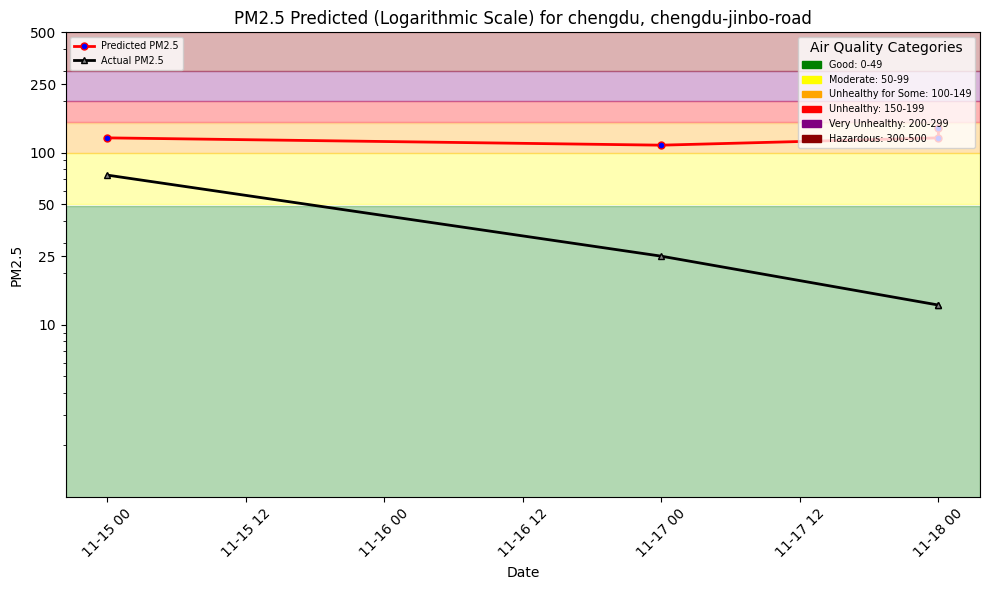

In [47]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---